1. IMPORT AND INSTALL DEPENDENCIES

In [1]:
import cv2
import numpy as np
import os
import time
import mediapipe as mp
import matplotlib
import matplotlib.pyplot as plt

2. KEYPOINTS USING MP HOLISTIC

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image, results  

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image,results.face_landmarks, mp_holistic.FACE_CONNECTIONS)
    mp_drawing.draw_landmarks(image,results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image,results.face_landmarks, mp_holistic.FACE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness = 1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness = 1, circle_radius=1)
                             )
    mp_drawing.draw_landmarks(image,results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness = 2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness = 2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness = 2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness = 2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness = 2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness = 2, circle_radius=2)
                             )

In [6]:
mp_holistic.POSE_CONNECTIONS
mp_drawing.draw_landmarks??

In [7]:
cap = cv2.VideoCapture(1)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        print(results)

        draw_styled_landmarks(image,results)
        
        cv2.imshow('OpenCV Feed', image)
        key = cv2.waitKey(30)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break    
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

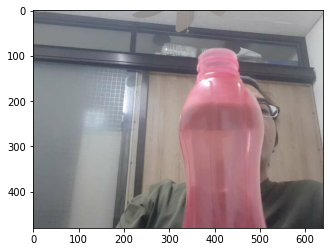

In [8]:
draw_landmarks(frame,results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

3. EXTRACT KEYPOINT VALUES

In [9]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [29]:
33*4+468*3+21*3*2

1662

In [10]:
result_test = extract_keypoints(results)
result_test

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
np.save('0', result_test)

In [12]:
np.load('0.npy')

array([0., 0., 0., ..., 0., 0., 0.])

4. SETUP FOLDERS FOR COLLECTION

In [15]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [20]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

5. COLLECT KEYPOINT VALUES FOR TRAINING AND TESTING

In [21]:
cap = cv2.VideoCapture(1)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

6. PREPROCESS DATA AND CREATE LABELS FEATURES

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [16]:
label_map = {label:num for num, label in enumerate(actions)}

In [17]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [18]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [19]:
np.array(sequences).shape

(90, 30, 1662)

In [20]:
np.array(labels).shape #ambil angka yang menandakan ini gaya apa (0 = hello, 1 = thanks, 2 = i love you)

(90,)

In [21]:
X = np.array(sequences)

In [22]:
X.shape #total 90 video, per video punya 30 frame, per frame punya 1662 titik/keypoints

(90, 30, 1662)

In [23]:
y = to_categorical(labels).astype(int)

In [27]:
y.shape

(90, 3)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [26]:
y_test.shape

(5, 3)

7. BUILD AND TRAIN LSTM NEURAL NETWORK

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [32]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [33]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [34]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [37]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
3/3 [==============================] - 0s 107ms/step - loss: 5.8302 - categorical_accuracy: 0.6471
Epoch 2/1000
3/3 [==============================] - 0s 48ms/step - loss: 9.7482 - categorical_accuracy: 0.6588
Epoch 3/1000
3/3 [==============================] - 0s 48ms/step - loss: 6.8001 - categorical_accuracy: 0.6471
Epoch 4/1000
3/3 [==============================] - 0s 48ms/step - loss: 3.1491 - categorical_accuracy: 0.7882
Epoch 5/1000
3/3 [==============================] - 0s 48ms/step - loss: 5.0034 - categorical_accuracy: 0.6824
Epoch 6/1000
3/3 [==============================] - 0s 50ms/step - loss: 6.3631 - categorical_accuracy: 0.6706
Epoch 7/1000
3/3 [==============================] - 0s 48ms/step - loss: 11.1364 - categorical_accuracy: 0.6588
Epoch 8/1000
3/3 [==============================] - 0s 48ms/step - loss: 3.3854 - categorical_accuracy: 0.7412
Epoch 9/1000
3/3 [==============================] - 0s 49ms/step - loss: 3.9588 - categorical_accuracy: 0.7412

3/3 [==============================] - 0s 51ms/step - loss: 22.7265 - categorical_accuracy: 0.3647
Epoch 75/1000
3/3 [==============================] - 0s 48ms/step - loss: 37.9065 - categorical_accuracy: 0.3294
Epoch 76/1000
3/3 [==============================] - 0s 49ms/step - loss: 36.7792 - categorical_accuracy: 0.3647
Epoch 77/1000
3/3 [==============================] - 0s 48ms/step - loss: 18.8213 - categorical_accuracy: 0.3059
Epoch 78/1000
3/3 [==============================] - 0s 47ms/step - loss: 23.4487 - categorical_accuracy: 0.3412
Epoch 79/1000
3/3 [==============================] - 0s 49ms/step - loss: 10.0855 - categorical_accuracy: 0.3765
Epoch 80/1000
3/3 [==============================] - 0s 48ms/step - loss: 22.2532 - categorical_accuracy: 0.2941
Epoch 81/1000
3/3 [==============================] - 0s 48ms/step - loss: 12.1062 - categorical_accuracy: 0.3294
Epoch 82/1000
3/3 [==============================] - 0s 49ms/step - loss: 9.7114 - categorical_accuracy: 0.317

3/3 [==============================] - 0s 47ms/step - loss: 25.3058 - categorical_accuracy: 0.2706
Epoch 147/1000
3/3 [==============================] - 0s 50ms/step - loss: 17.8473 - categorical_accuracy: 0.3294
Epoch 148/1000
3/3 [==============================] - 0s 49ms/step - loss: 18.7955 - categorical_accuracy: 0.3412
Epoch 149/1000
3/3 [==============================] - 0s 47ms/step - loss: 50.8500 - categorical_accuracy: 0.2941
Epoch 150/1000
3/3 [==============================] - 0s 47ms/step - loss: 43.9139 - categorical_accuracy: 0.3059
Epoch 151/1000
3/3 [==============================] - 0s 48ms/step - loss: 28.8846 - categorical_accuracy: 0.3882
Epoch 152/1000
3/3 [==============================] - 0s 46ms/step - loss: 67.6858 - categorical_accuracy: 0.3412
Epoch 153/1000
3/3 [==============================] - 0s 48ms/step - loss: 51.2476 - categorical_accuracy: 0.3294
Epoch 154/1000
3/3 [==============================] - 0s 48ms/step - loss: 41.0962 - categorical_accura

3/3 [==============================] - 0s 48ms/step - loss: 5.8779 - categorical_accuracy: 0.5059
Epoch 218/1000
3/3 [==============================] - 0s 48ms/step - loss: 6.7935 - categorical_accuracy: 0.4941
Epoch 219/1000
3/3 [==============================] - 0s 48ms/step - loss: 4.2131 - categorical_accuracy: 0.5765
Epoch 220/1000
3/3 [==============================] - 0s 48ms/step - loss: 5.6006 - categorical_accuracy: 0.4706
Epoch 221/1000
3/3 [==============================] - 0s 48ms/step - loss: 13.7198 - categorical_accuracy: 0.3647
Epoch 222/1000
3/3 [==============================] - 0s 49ms/step - loss: 21.1094 - categorical_accuracy: 0.4353
Epoch 223/1000
3/3 [==============================] - 0s 48ms/step - loss: 18.8886 - categorical_accuracy: 0.4706
Epoch 224/1000
3/3 [==============================] - 0s 49ms/step - loss: 18.0587 - categorical_accuracy: 0.3647
Epoch 225/1000
3/3 [==============================] - 0s 48ms/step - loss: 14.3752 - categorical_accuracy: 

3/3 [==============================] - 0s 49ms/step - loss: 3.6722 - categorical_accuracy: 0.5882
Epoch 290/1000
3/3 [==============================] - 0s 48ms/step - loss: 2.4539 - categorical_accuracy: 0.6706
Epoch 291/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.4620 - categorical_accuracy: 0.6706
Epoch 292/1000
3/3 [==============================] - 0s 49ms/step - loss: 2.0855 - categorical_accuracy: 0.5412
Epoch 293/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.6013 - categorical_accuracy: 0.5882
Epoch 294/1000
3/3 [==============================] - 0s 49ms/step - loss: 1.5058 - categorical_accuracy: 0.6353
Epoch 295/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.3365 - categorical_accuracy: 0.6471
Epoch 296/1000
3/3 [==============================] - 0s 49ms/step - loss: 1.2429 - categorical_accuracy: 0.6471
Epoch 297/1000
3/3 [==============================] - 0s 49ms/step - loss: 1.5777 - categorical_accuracy: 0.623

3/3 [==============================] - 0s 48ms/step - loss: 1.2257 - categorical_accuracy: 0.6353
Epoch 362/1000
3/3 [==============================] - 0s 49ms/step - loss: 1.0726 - categorical_accuracy: 0.6235
Epoch 363/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.1128 - categorical_accuracy: 0.6118
Epoch 364/1000
3/3 [==============================] - 0s 49ms/step - loss: 1.3177 - categorical_accuracy: 0.6824
Epoch 365/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.6291 - categorical_accuracy: 0.6353
Epoch 366/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.7742 - categorical_accuracy: 0.6118
Epoch 367/1000
3/3 [==============================] - 0s 46ms/step - loss: 1.1807 - categorical_accuracy: 0.6471
Epoch 368/1000
3/3 [==============================] - 0s 47ms/step - loss: 2.0044 - categorical_accuracy: 0.6471
Epoch 369/1000
3/3 [==============================] - 0s 48ms/step - loss: 2.1486 - categorical_accuracy: 0.635

3/3 [==============================] - 0s 48ms/step - loss: 0.8114 - categorical_accuracy: 0.6471
Epoch 434/1000
3/3 [==============================] - 0s 47ms/step - loss: 1.1388 - categorical_accuracy: 0.6588
Epoch 435/1000
3/3 [==============================] - 0s 48ms/step - loss: 2.0175 - categorical_accuracy: 0.6471
Epoch 436/1000
3/3 [==============================] - 0s 49ms/step - loss: 1.9926 - categorical_accuracy: 0.6824
Epoch 437/1000
3/3 [==============================] - 0s 47ms/step - loss: 1.7415 - categorical_accuracy: 0.6235
Epoch 438/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.1428 - categorical_accuracy: 0.6941
Epoch 439/1000
3/3 [==============================] - 0s 48ms/step - loss: 2.9748 - categorical_accuracy: 0.5882
Epoch 440/1000
3/3 [==============================] - 0s 48ms/step - loss: 2.0593 - categorical_accuracy: 0.6941
Epoch 441/1000
3/3 [==============================] - 0s 47ms/step - loss: 2.3877 - categorical_accuracy: 0.670

3/3 [==============================] - 0s 49ms/step - loss: 8.2514 - categorical_accuracy: 0.3412
Epoch 506/1000
3/3 [==============================] - 0s 48ms/step - loss: 8.8594 - categorical_accuracy: 0.3647
Epoch 507/1000
3/3 [==============================] - 0s 47ms/step - loss: 4.8984 - categorical_accuracy: 0.3647
Epoch 508/1000
3/3 [==============================] - 0s 47ms/step - loss: 3.8805 - categorical_accuracy: 0.4824
Epoch 509/1000
3/3 [==============================] - 0s 48ms/step - loss: 4.9467 - categorical_accuracy: 0.4235
Epoch 510/1000
3/3 [==============================] - 0s 48ms/step - loss: 5.9044 - categorical_accuracy: 0.3412
Epoch 511/1000
3/3 [==============================] - 0s 47ms/step - loss: 6.3973 - categorical_accuracy: 0.4235
Epoch 512/1000
3/3 [==============================] - 0s 48ms/step - loss: 5.5869 - categorical_accuracy: 0.3059
Epoch 513/1000
3/3 [==============================] - 0s 49ms/step - loss: 4.3827 - categorical_accuracy: 0.400

3/3 [==============================] - 0s 51ms/step - loss: 2.3906 - categorical_accuracy: 0.5529
Epoch 578/1000
3/3 [==============================] - 0s 49ms/step - loss: 3.9665 - categorical_accuracy: 0.4235
Epoch 579/1000
3/3 [==============================] - 0s 48ms/step - loss: 3.1013 - categorical_accuracy: 0.4471
Epoch 580/1000
3/3 [==============================] - 0s 49ms/step - loss: 3.3361 - categorical_accuracy: 0.4235
Epoch 581/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.8787 - categorical_accuracy: 0.5059
Epoch 582/1000
3/3 [==============================] - 0s 49ms/step - loss: 1.8243 - categorical_accuracy: 0.5529
Epoch 583/1000
3/3 [==============================] - 0s 49ms/step - loss: 2.0726 - categorical_accuracy: 0.5059
Epoch 584/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.9792 - categorical_accuracy: 0.5294
Epoch 585/1000
3/3 [==============================] - ETA: 0s - loss: 2.9215 - categorical_accuracy: 0.37 - 0s 

3/3 [==============================] - 0s 48ms/step - loss: 1.6614 - categorical_accuracy: 0.5882
Epoch 649/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.5521 - categorical_accuracy: 0.5647
Epoch 650/1000
3/3 [==============================] - 0s 47ms/step - loss: 2.3975 - categorical_accuracy: 0.4941
Epoch 651/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.5891 - categorical_accuracy: 0.5529
Epoch 652/1000
3/3 [==============================] - 0s 48ms/step - loss: 2.3933 - categorical_accuracy: 0.4824
Epoch 653/1000
3/3 [==============================] - 0s 49ms/step - loss: 2.0224 - categorical_accuracy: 0.6353
Epoch 654/1000
3/3 [==============================] - 0s 48ms/step - loss: 3.3623 - categorical_accuracy: 0.4353
Epoch 655/1000
3/3 [==============================] - 0s 48ms/step - loss: 4.7837 - categorical_accuracy: 0.3765
Epoch 656/1000
3/3 [==============================] - 0s 47ms/step - loss: 6.3693 - categorical_accuracy: 0.470

3/3 [==============================] - 0s 48ms/step - loss: 3.6802 - categorical_accuracy: 0.4471
Epoch 721/1000
3/3 [==============================] - 0s 49ms/step - loss: 4.8419 - categorical_accuracy: 0.5529
Epoch 722/1000
3/3 [==============================] - 0s 48ms/step - loss: 7.8428 - categorical_accuracy: 0.4118
Epoch 723/1000
3/3 [==============================] - 0s 47ms/step - loss: 3.0085 - categorical_accuracy: 0.4118
Epoch 724/1000
3/3 [==============================] - 0s 47ms/step - loss: 3.8359 - categorical_accuracy: 0.5176
Epoch 725/1000
3/3 [==============================] - 0s 47ms/step - loss: 4.3903 - categorical_accuracy: 0.5059
Epoch 726/1000
3/3 [==============================] - 0s 48ms/step - loss: 4.8824 - categorical_accuracy: 0.4353
Epoch 727/1000
3/3 [==============================] - 0s 48ms/step - loss: 3.2678 - categorical_accuracy: 0.5765
Epoch 728/1000
3/3 [==============================] - 0s 49ms/step - loss: 3.0891 - categorical_accuracy: 0.588

3/3 [==============================] - 0s 48ms/step - loss: 0.8828 - categorical_accuracy: 0.7294
Epoch 793/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.7134 - categorical_accuracy: 0.6824
Epoch 794/1000
3/3 [==============================] - 0s 47ms/step - loss: 1.0889 - categorical_accuracy: 0.7059
Epoch 795/1000
3/3 [==============================] - 0s 49ms/step - loss: 0.7273 - categorical_accuracy: 0.7059
Epoch 796/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.8129 - categorical_accuracy: 0.7059
Epoch 797/1000
3/3 [==============================] - 0s 47ms/step - loss: 0.7411 - categorical_accuracy: 0.7176
Epoch 798/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.0622 - categorical_accuracy: 0.6824
Epoch 799/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.7559 - categorical_accuracy: 0.7412
Epoch 800/1000
3/3 [==============================] - 0s 47ms/step - loss: 0.7558 - categorical_accuracy: 0.682

3/3 [==============================] - 0s 47ms/step - loss: 0.9415 - categorical_accuracy: 0.6941
Epoch 865/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.7098 - categorical_accuracy: 0.7294
Epoch 866/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.5207 - categorical_accuracy: 0.7647
Epoch 867/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.5108 - categorical_accuracy: 0.7882
Epoch 868/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.8442 - categorical_accuracy: 0.6941
Epoch 869/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.6260 - categorical_accuracy: 0.7294
Epoch 870/1000
3/3 [==============================] - 0s 50ms/step - loss: 0.9961 - categorical_accuracy: 0.6824
Epoch 871/1000
3/3 [==============================] - 0s 47ms/step - loss: 1.3838 - categorical_accuracy: 0.6941
Epoch 872/1000
3/3 [==============================] - 0s 49ms/step - loss: 1.6129 - categorical_accuracy: 0.635

3/3 [==============================] - 0s 49ms/step - loss: 0.5374 - categorical_accuracy: 0.7176
Epoch 937/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.4697 - categorical_accuracy: 0.8000
Epoch 938/1000
3/3 [==============================] - 0s 49ms/step - loss: 0.8215 - categorical_accuracy: 0.7294
Epoch 939/1000
3/3 [==============================] - 0s 52ms/step - loss: 0.5963 - categorical_accuracy: 0.7294
Epoch 940/1000
3/3 [==============================] - 0s 50ms/step - loss: 0.5747 - categorical_accuracy: 0.7294
Epoch 941/1000
3/3 [==============================] - 0s 49ms/step - loss: 1.5764 - categorical_accuracy: 0.5647 0s - loss: 1.5742 - categorical_accuracy: 0.54
Epoch 942/1000
3/3 [==============================] - 0s 50ms/step - loss: 0.7712 - categorical_accuracy: 0.7529
Epoch 943/1000
3/3 [==============================] - 0s 50ms/step - loss: 0.6176 - categorical_accuracy: 0.7529
Epoch 944/1000
3/3 [==============================] - 0s 49ms/st

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            442112    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
__________________________________________________

8. MAKE PREDICTIONS

In [39]:
res = model.predict(X_test)

In [40]:
actions[np.argmax(res[4])]

'thanks'

In [41]:
actions[np.argmax(y_test[4])]

'thanks'

9. SAVE WEIGHTS

In [42]:
model.save('action.h5')

In [ ]:
del model

In [ ]:
model.load_weights('action.h5')

10. EVALUATION USING CONFUSION MATRIX AND ACCURACY

In [44]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [45]:
yhat = model.predict(X_test)

In [46]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [47]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [1, 0]],

       [[2, 1],
        [0, 2]],

       [[3, 0],
        [0, 2]]], dtype=int64)

In [48]:
accuracy_score(ytrue, yhat)

0.8

11. TEST IN REAL TIME

In [49]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(1)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'me